In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # for notebooks
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [363]:
load_icp = True

if load_icp:
    df_long = pd.read_csv("data/Datenbank_icp.csv")
else:
    df_long = pd.read_csv("data/Datenbank_Werte.csv")
    
    # add type to Maßnahme
    df_long["Maßnahme"] += "_" + df_long["ID"]
    df_long = df_long.drop(columns="ID")
    
    # remove patients without ICP measurement
    # drop from 220M measuremnts to 130M
    df_long = df_long.groupby("Pat_ID").filter(lambda group: any(group["Maßnahme"] == "ICP_Vital"))
    
    # drop measurements where we have a "NAN"
    df_long = df_long.dropna(subset=["Wert"])

    df_long.to_csv("data/Datenbank_icp.csv", index=False)
print("Data loaded!")

/home/anton/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Data loaded!


In [364]:
print("Columns: ", list(df_long.columns))
print(df_long.head())
print(df_long.shape)
#print(df_long["Maßnahme"].unique())
#print(df_long["Maßnahme_norm"].unique())

Columns:  ['Pat_ID', 'Maßnahme', 'Maßnahme_norm', 'rel_time', 'Wert', 'DB']
      Pat_ID Maßnahme Maßnahme_norm  rel_time  Wert   DB
1  474097135   Ca_BGA            Ca     419.0  1.23  UKE
2  474097135   Ca_BGA            Ca     492.0  1.28  UKE
3  474097135   Ca_BGA            Ca     558.0  1.29  UKE
4  474097135   Ca_BGA            Ca     675.0  1.31  UKE
5  474097135   Ca_BGA            Ca     764.0  1.31  UKE
(153247310, 6)


In [74]:
load_reduced = True

if load_reduced:
    df_long = pd.read_csv("data/Datenbank_icp_reduced.csv")
else:
    # remove measurement past the last icp measurement per patient
    # cuts from 130M to 100M
    def drop_after_last_icp(pat):
        icp_rel_times = pat[pat["Maßnahme"] == "ICP_Vital"]["rel_time"]
        if len(icp_rel_times) == 0:
            return pd.DataFrame({})
        max_icp_time = max(icp_rel_times)
        pat = pat[pat["rel_time"] <= max_icp_time]
        return pat
    df_long = df_long.groupby("Pat_ID").apply(drop_after_last_icp).reset_index(drop=True)
    print(df_long.shape)
    
    # remove too negative rel_times and shorten too long stays
    # remove too negative rel_times
    # 1. find smallest icp time
    below_zero = df_long["rel_time"] < 0
    below_zero_df = df_long[below_zero]
    min_icp_time = below_zero_df[below_zero_df["Maßnahme"] == "ICP_Vital"]["rel_time"].min()
    print("smallest icp rel time:", min_icp_time)
    # 2. drop all rel_times below it
    df_long_no_too_small_icp = df_long[df_long["rel_time"] >= min_icp_time]
    # 3. shift rel_time per patient such that it is positive
    def shift_rel_time_to_pos(pat):
        min_time = pat["rel_time"].min()
        pat["rel_time"] = pat["rel_time"] + abs(min_time)
        return pat
    df_long_no_neg_rel_time = df_long_no_too_small_icp.groupby("Pat_ID").apply(shift_rel_time_to_pos)
    print(df_long_no_neg_rel_time.shape)
    
    # shorten long stays
    # reduces from 103M to 99M
    # 1. find max rel_times
    max_rel_times = df_long_no_neg_rel_time.groupby("Pat_ID").apply(lambda group: group["rel_time"].max())
    print(max_rel_times.min(), max_rel_times.max(), max_rel_times.mean())
    # 2. get quantile
    quant = np.quantile(max_rel_times, 0.95)
    print("Rel_time quantile: ", quant)
    # 3. filter too long rel_times per patient by cutting off START (end contains ICP measurements for sure)
    def cut_off_start_rel_times(pat):
        max_rel_time = max(pat["rel_time"])
        if max_rel_time > quant:
            cutoff_len = max_rel_time - quant
            pat = pat[pat["rel_time"] > cutoff_len]
        return pat
    df_cutoff_long_seqs = df_long_no_neg_rel_time.groupby("Pat_ID").apply(cut_off_start_rel_times)
    print(df_cutoff_long_seqs.shape)
    
    # clamp extreme measures
    def clamp_extrema(measure, thresh=0.996):
        min_quant = np.quantile(measure["Wert"], 1 - thresh)
        max_quant = np.quantile(measure["Wert"], thresh)
        measure["Wert"] = measure["Wert"].clip(min_quant, max_quant)
        return measure
    df_long = df_cutoff_long_seqs.groupby("DB").apply(lambda db: db.groupby("Maßnahme").apply(clamp_extrema)).reset_index(drop=True)
    
    # remove CPP as it is dependent on ICP and we want to predict ICP
    df_long = df_long[df_long["Maßnahme"] != "CPP_Vital"]
    
    # save
    df_long.to_csv("data/Datenbank_icp_reduced.csv", index=False)

/home/anton/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# determine columns that have few missings - add min, max, std for those
val_counts = df_long.groupby("DB").apply(lambda db: db.groupby("Maßnahme").apply(lambda m: len(m))).reset_index(drop=False)
val_counts = val_counts.groupby("Maßnahme").mean()[0]
val_counts

Maßnahme
AF_Vital              1.137706e+06
ALT_Labor             3.079000e+03
AST_Labor             3.033667e+03
Albumin_Labor         2.783667e+03
Alk_Labor             2.079667e+03
                          ...     
pH_BGA                4.718033e+04
pankreasspez_Labor    8.023333e+02
sO2_BGA               4.168167e+04
syst_NBD_Vital        1.695480e+05
syst_Vital            5.834560e+05
Name: 0, Length: 83, dtype: float64

In [4]:
# select high count vitals 
quant = np.quantile(val_counts, 0.78)
print(quant)
mask = (val_counts > quant).astype(int) + val_counts.index.str.contains("_Vital").astype(int) +  (~val_counts.index.str.contains("ICP")).astype(int)
mask = mask == 3
high_counts = val_counts[mask].sort_values(0)
print(high_counts)
high_counts = tuple(high_counts.index)

131334.54666666666
Maßnahme
FiO2_Vital         1.313877e+05
diast_NBD_Vital    1.694910e+05
syst_NBD_Vital     1.695480e+05
mittl_NBD_Vital    1.698680e+05
Temp_Vital         3.148330e+05
diast_Vital        5.826100e+05
syst_Vital         5.834560e+05
mittl_Vital        5.857483e+05
SpO2_Vital         1.131266e+06
AF_Vital           1.137706e+06
HF_Vital           1.185037e+06
Name: 0, dtype: float64


In [5]:
minutes = 60

In [6]:
from typing import Tuple, List

import numba


@numba.jit()
def create_dict(values: np.ndarray, rel_time: np.ndarray, measure_name: str, high_counts: Tuple[str]):
    means = []
    stds = []
    mins = []
    maxs = []
    rel_times = []
    i = 0
    while i < len(values): 
        # add consequent measurements as long as they fit in time window
        # subtract remainder to make sure rel_times are fitted in the right time window
        current_rel_time = rel_time[i] - (rel_time[i] % minutes)  
        vals = []
        while i < len(values) and rel_time[i] < current_rel_time + minutes:
            vals.append(values[i])
            i += 1
        # summarize values
        vals = np.array(vals)
        means.append(np.mean(vals))
        rel_times.append(current_rel_time)
        # add detailed summary if it is a high count feature
        if measure_name in high_counts:
            stds.append(np.std(vals))
            mins.append(np.min(vals))
            maxs.append(np.max(vals))
    return means, stds, mins, maxs, rel_times


def summarize_measure(measure, high_counts, minutes):
    # get name and relevant columns
    measure_name = measure["Maßnahme"].iloc[0]
    rel_time = measure["rel_time"].to_numpy().astype(float)
    values = measure["Wert"].to_numpy().astype(float)
    # get lists
    means, stds, mins, maxs, rel_time = create_dict(values, rel_time, measure_name, high_counts)
    # create new, shorter df with same base stats (Pat_ID etc.)
    new_df = pd.DataFrame({"rel_time": rel_time, "Wert": means})
    new_df["Pat_ID"] = measure["Pat_ID"].iloc[0]
    new_df["Maßnahme"] = measure["Maßnahme"].iloc[0]
    new_df["Maßnahme_norm"] = measure["Maßnahme_norm"].iloc[0]
    new_df["DB"] = measure["DB"].iloc[0]
    if len(stds) > 0:
        # if we have additional stats for this feature, copy the df above, fill in other value and append it
        new_measures = {measure_name: means,
                        measure_name + "_std": stds,
                        measure_name + "_min": mins,
                        measure_name + "_max": maxs} 
        dfs = [new_df.copy() for key in new_measures]
        for df, key in zip(dfs, new_measures):
            df["Maßnahme"] = key
            df["Wert"] = new_measures[key]
        new_df = pd.concat(dfs, axis=0)
    return new_df
            

def summarize_patient(pat, minutes):
    # assumes a patient, sorted by rel_time, with 1 minute steps
    return pat.groupby("Maßnahme").apply(lambda measure: summarize_measure(measure, high_counts, minutes)).reset_index(drop=True)

df_long_summarized = df_long.groupby("Pat_ID").progress_apply(lambda pat: summarize_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)
# summarize per N minutes (5 min, 60 min) 
# take mean, min, max, std per Vital measure

  0%|          | 0/3775 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# norm med by maßnahme norm per db
meds = [feat for feat in df_long_summarized["Maßnahme"].unique() if "_Med" in feat]
def norm_group(group):
    if group["Maßnahme"].iloc[0] in meds:
        group["Wert"] = (group["Wert"] - group["Wert"].mean()) / group["Wert"].std()
    return group
df_long_normed_med = df_long_summarized.groupby("DB").apply(lambda db: db.groupby("Maßnahme_norm").apply(norm_group)).reset_index(drop=True)
#df_long = df_long.drop(columns=["Maßnahme_norm"])

In [ ]:
# from long to wide
df = df_long_normed_med.pivot_table(index=["rel_time", "Pat_ID", "DB"], columns="Maßnahme", values="Wert").reset_index()

In [525]:
df.to_csv(f"data/df_wide_{minutes}.csv", index=False)

In [ ]:
# fill in rows with NAN where we have no measurement at all

num_rows_added = []

def add_nan_rows(arr: np.ndarray, rel_time: np.ndarray, minutes: int):
    # check dist between all consecutive rel_times and create NaN array, which is added to list. Merge this list in the end
    num_feats = arr.shape[1]
    rows = []
    old_time = rel_time[0]
    for row, t in zip(arr, rel_time):
        #print(t)
        # check how many rows between old_time and current time have to be added
        num_rows = int(np.ceil((t - old_time) / minutes)) - 1
        if num_rows > 0:
            #print(num_rows)
            num_rows_added.append(num_rows)
            new_rows = np.ones((num_rows, num_feats)) * np.nan
            rows.append(new_rows)
        rows.append(np.expand_dims(row, 0))
        old_time = t
    return np.concatenate(rows, axis=0)


def unroll_patient(pat, minutes):
    # assumes a patient, sorted by rel_time
    # transform to numpy array and move to helper function
    rel_time = pat["rel_time"].to_numpy()
    db = pat["DB"].iloc[0]
    pat_id = pat["Pat_ID"].iloc[0]
    # drop DB and pat_id temporarily, as their type is str
    pat = pat.drop(columns=["DB", "Pat_ID"]).astype(np.float32)
    arr = pat.to_numpy()

    # get new_array that contains nan_rows where necessary
    #print("old array shape: ", pat.shape)
    new_array = add_nan_rows(arr, rel_time, minutes)
    #print("new array shape: ", new_array.shape)
    # set Pat_ID, rel_time and col names correctly at end
    new_pat = pd.DataFrame(data=new_array, columns=pat.columns, index=np.arange(len(new_array)))
    new_pat["DB"] = db 
    new_pat["Pat_ID"] = pat_id
    # fill in rel_times
    start_time = pat["rel_time"].iloc[0]
    new_pat["rel_time"] = np.arange(start_time, start_time + len(new_pat) * minutes, minutes)
    return new_pat
    

df_filled = df.groupby("Pat_ID").progress_apply(lambda pat: unroll_patient(pat.sort_values("rel_time", ascending=True), minutes)).reset_index(drop=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
np.mean(num_rows_added)

In [ ]:
p = plt.hist(num_rows_added, bins=100)
plt.xlabel("Num consecutive missing steps")

In [ ]:
len(num_rows_added)

In [ ]:
df_filled

In [532]:
df_filled.to_csv(f"data/df_filled_{minutes}.csv", index=False)

In [4]:
minutes = 60
df_filled = pd.read_csv(f"data/df_filled_{minutes}.csv", index_col=0)

/home/anton/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (119) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# remove feature that have N% missing spots in at least one database
threshold = 1 - (1 - 0.99) / (60 / minutes)  # make it such that it is 0.99 for 60 minutes and 0.999 for 5 minutes
max_nan_frac_over_dbs = df_filled.groupby("DB").apply(lambda db: db.isna().mean()).max().sort_values()
drop_cols = list(max_nan_frac_over_dbs[max_nan_frac_over_dbs > threshold].index)
df_drop_too_missing = df_filled.drop(columns=drop_cols)
print("Dropped: ", drop_cols, " - ", len(drop_cols))

Dropped:  ['Albumin_Labor', 'Alk_Labor', 'CK_Labor', 'Leukocyten_Labor', 'Erythrocyten_Labor', 'Troponin_Labor', 'Barbiturat_Med', 'CK-MB_Labor', 'Lymphocyten_Labor', 'Basophile_Labor', 'Monocyten_Labor', 'Eosinophile_Labor', 'Lipase_Labor', 'Neutrophile_Labor', 'Triglyceride_Labor', 'pankreasspez_Labor', 'TSH_Labor', 'LDH_Labor', 'Cholesterin_Labor', 'FCOHb_BGA', 'CRP_Labor', 'RASS_Vital', 'fT4_Labor', 'fT3_Labor', 'FiO2_BGA', 'Bili_BGA']  -  26


In [6]:
# fill med missing with 0
df_med_filled = df_drop_too_missing.copy()
med_col_names = [col for col in df_med_filled.columns if "_Med" in col]
df_med_filled[med_col_names] = df_med_filled[med_col_names].fillna(df_med_filled[med_col_names].min())

In [7]:
# get patient data such as gender etc
df_static = pd.read_csv("data/Datenbank_Pat_ID.csv")
df_static = df_static[["Pat_ID", "Alter", "Diagnose_txt", "Geschlecht", "Größe", "Gewicht"]]
df_static = df_static.rename(columns={"Diagnose_txt": "Diagnose"})
# one-hot encode
df_static = pd.get_dummies(df_static, columns=["Diagnose", "Geschlecht"])
df_static = df_static.drop(columns=["Geschlecht_Weiblich"])
df_static = df_static.rename(columns={"Geschlecht_Männlich": "Geschlecht"})
# drop nan Pat_ID
df_static = df_static.dropna(subset=["Pat_ID"])

In [8]:
# merge
df_med_filled["Pat_ID"] = df_med_filled["Pat_ID"].astype(int)
df_static["Pat_ID"] = df_static["Pat_ID"].astype(int)
df_large = pd.merge(df_med_filled, df_static, on="Pat_ID", how="left")

In [9]:
# one-hot-encode DB
df_large = pd.get_dummies(df_large, columns=["DB"])

In [148]:
path = f"data/df_final_{minutes}.csv"
df_large.to_csv(path, index=False)
print("Saved to: ", path)

Saved to:  data/df_final_60.csv


In [21]:
import matplotlib.pyplot as plt

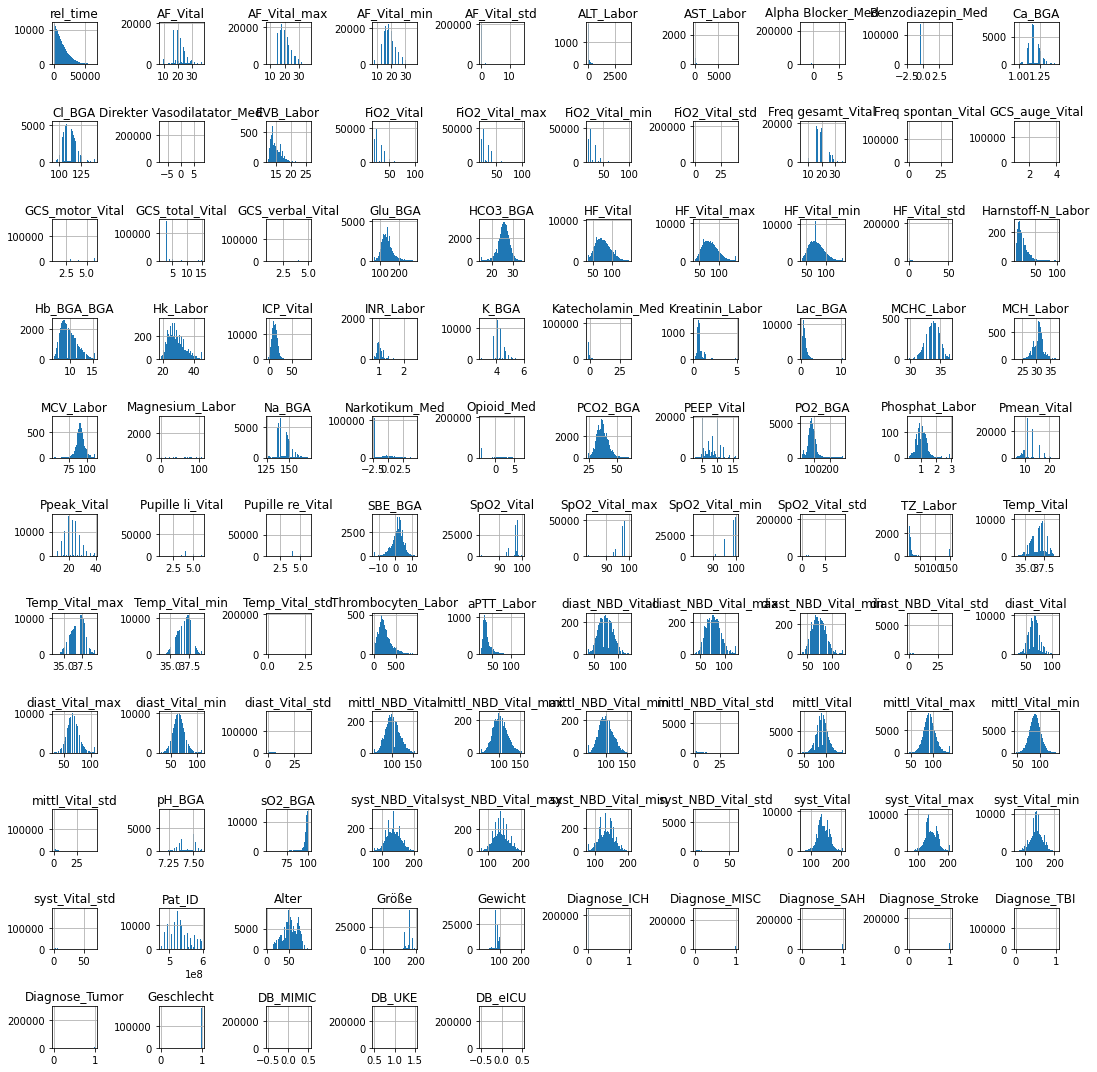

In [156]:
# check distributions
p = uke_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

In [12]:
from sklearn.preprocessing import PowerTransformer

transform = PowerTransformer(method='yeo-johnson', standardize=True)

In [151]:
uke_df = df_large[df_large["DB_UKE"] == 1]

In [105]:
uke_arr = uke_df.to_numpy()

In [106]:
transform.fit(uke_arr)

/home/anton/.local/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


PowerTransformer()

In [107]:
np.round(transform.lambdas_, 1)

array([  0.3,   0.1,   0. ,   0.1,  -6.7,  -0.3,  -0.4,  -2.1,   0.5,
        -2.7,  -2.2, -30.3,  -3.2,  -1.3,  -1.3,  -1.3, -68.8,   0.4,
        -1.6,  -7.3,  -7.2,  -1.8, -28.9,  -0.5,   1.9,   0.1,   0.1,
         0.1,  -2.7,  -0.2,  -0.9,  -0.7,   0.5,  -6.8,  -0.7,   0.3,
        -1.9,  -1.7,   4.7,   1.9,   2.6,  -3.3,  -3.6,   0.8,   1.1,
        -0.5,  -0.5,   0.4,  -0.1,  -0.3,   0.6,  -0.4,  -0.5,   1.1,
        19.3,  20.3,  18.8,  -9.2,  -2.1,   6.8,   6.5,   7. , -60.5,
         0.3,  -1.6,   0.5,   0.4,   0.5,  -2. ,   0.7,   0.6,   0.8,
        -2.1,   0.3,   0.2,   0.3,  -1.8,   0.9,   0.7,   1. ,  -1.8,
        32.5,  18.3,   0.6,   0.5,   0.7,  -1.6,   1.2,   1.2,   1.3,
        -1.4,  -2. ,   1.2,   3.8,   0.1,  -5.7, -16.7, -11.8, -10. ,
        -2.1, -48.4,   1.9,   8.5,   4.5,   8.5])

In [108]:
transformed_arr = transform.transform(uke_arr)

In [136]:
lambdas_ = transform.lambdas_
mask = np.abs(lambdas_) > 5
print(lambdas_[mask])

[ -6.74761296 -30.29670016 -68.78699886  -7.31345652  -7.16023783
 -28.91404399  -6.81024281  19.34138603  20.27741172  18.81332425
  -9.18781805   6.84437432   6.5089585    7.03552606 -60.45325766
  32.47157075  18.26612186  -5.69088847 -16.65354225 -11.80884252
  -9.98798876 -48.43999351   8.47213581   8.47213581]


In [124]:
transformed_df = pd.DataFrame(transformed_arr, columns=df_large.columns)#, index=df_large.index)

In [161]:
feat = "sO2_BGA"

In [162]:
idx = list(transformed_df.columns).index(feat)
lambdas_[idx]

18.266121856781986

In [163]:
uke_df[feat].describe()

count    105232.000000
mean         95.243883
std           7.138900
min          53.299999
25%          95.800003
50%          97.599998
75%          98.599998
max         100.000000
Name: sO2_BGA, dtype: float64

In [164]:
transformed_df[feat].describe()

count    1.052320e+05
mean    -1.696141e-16
std      1.000005e+00
min     -2.250734e+00
25%     -4.851976e-01
50%      2.212004e-01
75%      7.215354e-01
max      1.584746e+00
Name: sO2_BGA, dtype: float64

In [165]:
uke_df[feat].unique()

array([        nan, 99.69999695, 90.09999847, ..., 68.23332977,
       83.16666412, 68.83333588])

In [166]:
transformed_df[feat].unique()

array([        nan,  1.38189534, -1.66807607, ..., -2.24690651,
       -2.11353665, -2.24624527])

<AxesSubplot:>

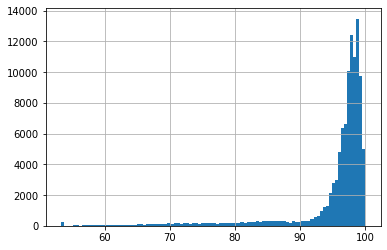

In [167]:
uke_df[feat].hist(bins=100)

<AxesSubplot:>

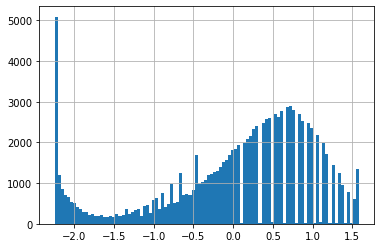

In [168]:
transformed_df[feat].hist(bins=100)

In [186]:
import numba
import numpy as np

@numba.jit()
def ema_fill(pat: np.ndarray, ema_val: float, mean: np.ndarray):
    # init ema
    ema = np.ones_like(pat[0]) * pat[0]
    ema[np.isnan(ema)] = mean[np.isnan(ema)]
    # run ema
    ema_steps = np.ones_like(pat)
    for i, pat_step in enumerate(pat):
        pat_step[np.isnan(pat_step)] = 0
        ema = ema_val * ema + (1 - ema_val) * pat_step
        ema_steps[i] = ema.copy()
    return ema_steps

In [178]:
mean = uke_df.mean().to_numpy()

In [187]:
uke_filled = uke_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, mean), columns=pat.columns))

In [294]:
def four_parts(df):
    leng = len(df)
    first = df.iloc[0: leng // 4].mean()
    second = df.iloc[leng // 4: leng // 2].mean()
    third = df.iloc[leng // 2: leng * 3 // 4].mean()
    fourth = df.iloc[leng * 3 // 4:].mean()
    all_parts = [first, second, third, fourth]
    return pd.DataFrame(all_parts, columns=df.columns)

In [296]:
umap_arr_red = umap_norm.reset_index(drop=True).groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()

In [298]:
umap_arr_dropped = umap_arr_red.drop(columns=["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]).to_numpy()

In [1118]:
from sklearn.preprocessing import PowerTransformer

def apply_yeo(df, thresh=50, lambs=None):
    transform = PowerTransformer(method='yeo-johnson', standardize=False)
    drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital", "rel_time"]
    dropped = df.drop(columns=drop_cols)
    arr = dropped.to_numpy()
    if lambs is None:
        # apply yeo
        transform.fit(arr)
        lambs = transform.lambdas_ 
        mask = np.abs(lambs) > thresh
        print(df["DB_MIMIC"].sum(), df["DB_UKE"].sum(), df["DB_eICU"].sum())
        print(mask.sum())
        #print(pd.Series(np.round(lambs, 1), index=dropped.columns).sort_values(np.abs(lambs)))
        print(np.round(lambs, 1))
        print()
        lambs[mask] = 1
    transform.lambdas_ = lambs
    trans_arr = transform.transform(arr)
    # merge back
    df = pd.concat([pd.DataFrame(trans_arr, columns=dropped.columns), df[drop_cols]], axis=1)
    return df, lambs

In [1119]:
def create_umap_df(df, yeo=False, lambs=None, mean=None, std=None, thresh=10):
    # apply yeo
    if yeo:
        df, _ = apply_yeo(df, lambs=lambs, thresh=thresh)
    # calc median
    median = df.median().to_numpy()
    # fill using ema
    df_filled = df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    # calc mean
    if mean is None:
        mean = df_filled.mean()
        std = df_filled.std()
        mean[std == 0] = 0
        std[std == 0] = 1
    #norm
    df_norm = (df_filled - mean) / std
    # average over four regions per Pat
    df_red = df_norm.groupby("Pat_ID").apply(four_parts).reset_index(drop=True).dropna()
    return df_red

In [1238]:
yeo = False
use_train_stats = False
thresh = 10

lambs = None
mean = None
std = None
    
if use_train_stats:
    train_df = df_large[df_large["DB_UKE"] == 1]
    if yeo:
        # calc lambdas for train dataset
        #train_df_filled = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.astype(float).sort_values("rel_time").to_numpy(), 0.9, train_df.median()), columns=pat.columns)).reset_index(drop=True)
        train_df, lambs = apply_yeo(train_df, thresh=thresh)
         # calc median
        median = train_df.median().to_numpy()
        # fill using ema
        train_df = train_df.groupby("Pat_ID").apply(lambda pat: pd.DataFrame(ema_fill(pat.sort_values("rel_time").to_numpy(), 0.9, median), columns=pat.columns)).reset_index(drop=True)
    
    # calc mean
    mean = train_df.mean().to_numpy()
    std = train_df.std()
    mean[std == 0] = 0
    std[std == 0] = 1


grouper = df_large["DB_UKE"] * 1 + df_large["DB_MIMIC"] * 2 + df_large["DB_eICU"] * 3
df_red = df_large.groupby(grouper).apply(lambda db: create_umap_df(db, yeo=yeo, lambs=lambs, mean=mean, std=std, thresh=thresh))
#df_red = transformed_df.groupby(grouper).apply(create_umap_df)

In [1239]:
if std is not None:
    std.sort_values()

In [1240]:
db_values = df_red["DB_UKE"] * 1 + df_red["DB_MIMIC"] * 2 + df_red["DB_eICU"] * 3
db_values[db_values == 1] = "UKE"
db_values[db_values == 2] = "MIMIC"
db_values[db_values == 3] = "eICU"

In [1241]:
# drop some cols and to numpy
drop_cols = ["DB_MIMIC", "DB_UKE", "DB_eICU", "Pat_ID", "ICP_Vital"]
#drop_cols.extend([col for col in df_red.columns if "_Med" in col])
#drop_cols.extend([col for col in df_red.columns if "Diagnose" in col])
#drop_cols.extend([col for col in df_red.columns if "BGA" in col])
#drop_cols.extend([col for col in df_red.columns if "Labor" in col])
#drop_cols.extend([col for col in df_red.columns if "Vital" in col])

#print(drop_cols)
dropped = df_red.drop(columns=drop_cols)
#print(dropped.columns)
arr = dropped.to_numpy()

In [1242]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].mean())

1    111.993626
2    106.624441
3    109.715337
dtype: float64

In [1243]:
df_used.groupby(grouper).apply(lambda db: db["Cl_BGA"].std())

1    7.528526
2    6.908850
3    8.501029
dtype: float64

In [1244]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].std())

MIMIC    1.374312
UKE      1.040520
eICU     1.483953
dtype: float64

In [1245]:
dropped.groupby(db_values).apply(lambda db: db["Cl_BGA"].mean())

MIMIC    0.580404
UKE      0.206471
eICU     0.670719
dtype: float64

In [1246]:
dropped["Cl_BGA"].std()

1.345830752874619

In [1247]:
from umap import UMAP
import umap.plot

umapper = UMAP(n_components=2, n_neighbors=15)
umapped_arr = umapper.fit_transform(arr)

In [1248]:
from sklearn.decomposition import PCA
mapper = PCA()

pca_arr = mapper.fit_transform(arr)
pca_arr.shape

(15002, 100)

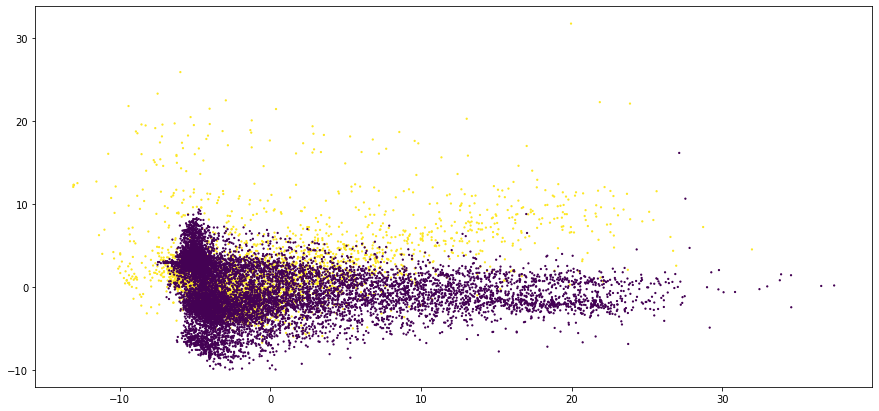

In [1249]:
colors = db_values.copy()
colors[colors=="UKE"] = "red"
colors[colors=="MIMIC"] = "blue"
colors[colors=="eICU"] = "green"

colors = df_red["DB_UKE"]
plt.figure(figsize=(15, 7))
plt.scatter(pca_arr[:, 0], pca_arr[:, 1], c=colors, s=1.5)

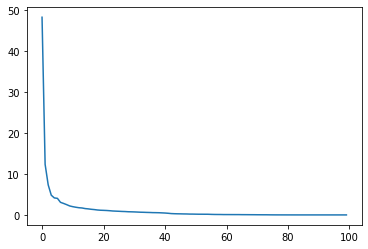

In [1250]:
plt.plot(mapper.explained_variance_)

6.544730990457621


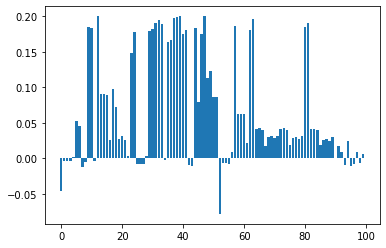

In [1251]:
comp_idx = 0
plt.bar(range(len(mapper.components_[comp_idx])), mapper.components_[comp_idx])
print(mapper.components_[comp_idx].sum())

In [1252]:
max_comp_idx = np.argmax(mapper.components_[comp_idx])
print(max_comp_idx)
print(dropped.columns[max_comp_idx])

47
Phosphat_Labor


In [1253]:
dropped.groupby(db_values).apply(lambda x: x["Temp_Vital"].std())

MIMIC    1.031269
UKE      0.862770
eICU     0.917302
dtype: float64

In [1254]:
#help(UMAP)

In [1255]:
#umap.plot.points(umapper, theme="fire", values=df_red["Pupille re_Vital"])

<AxesSubplot:>

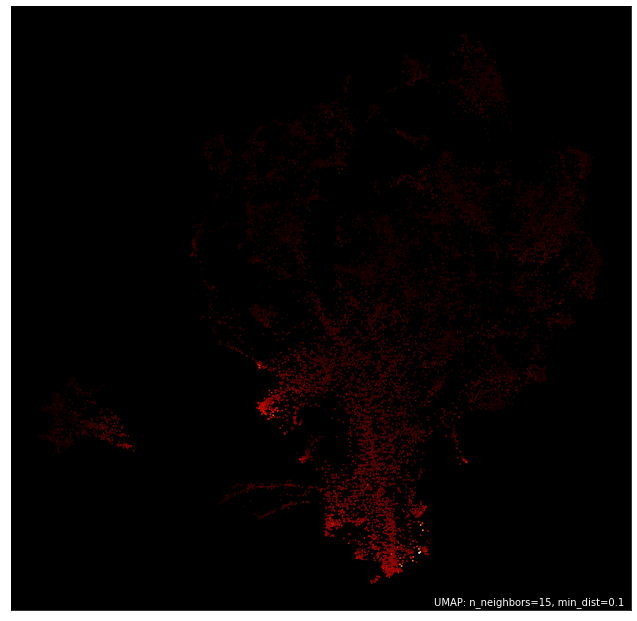

In [1256]:
umap.plot.points(umapper, theme="fire", values=df_red["Phosphat_Labor"])

<AxesSubplot:>

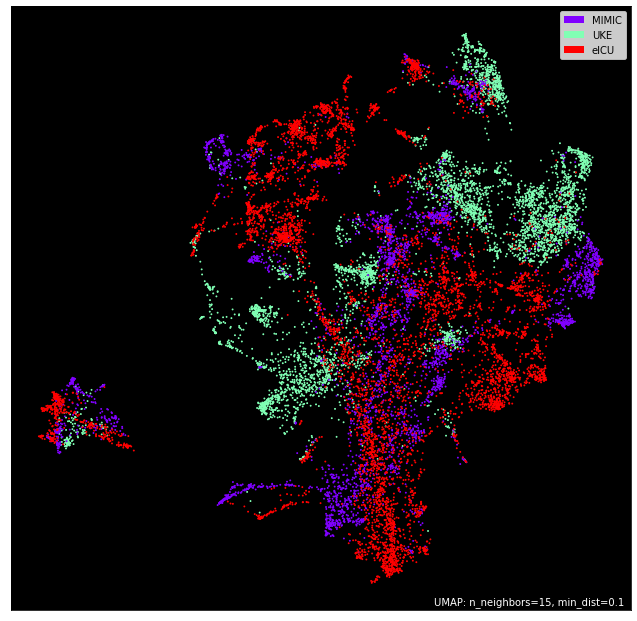

In [1257]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

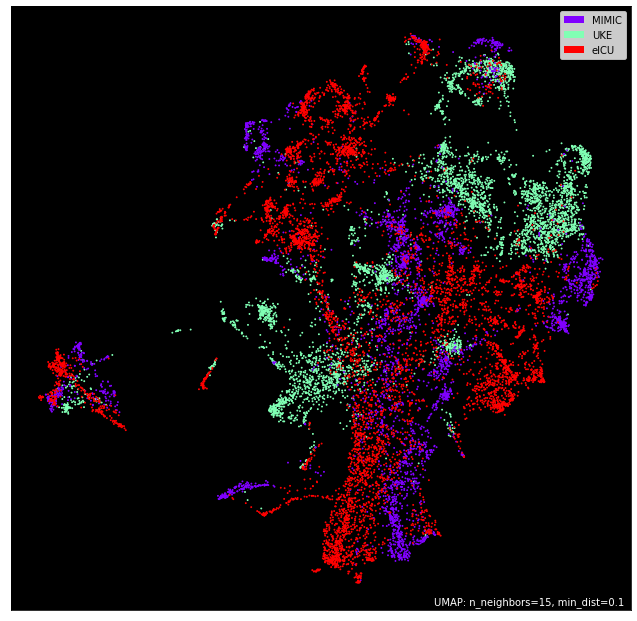

In [1196]:
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

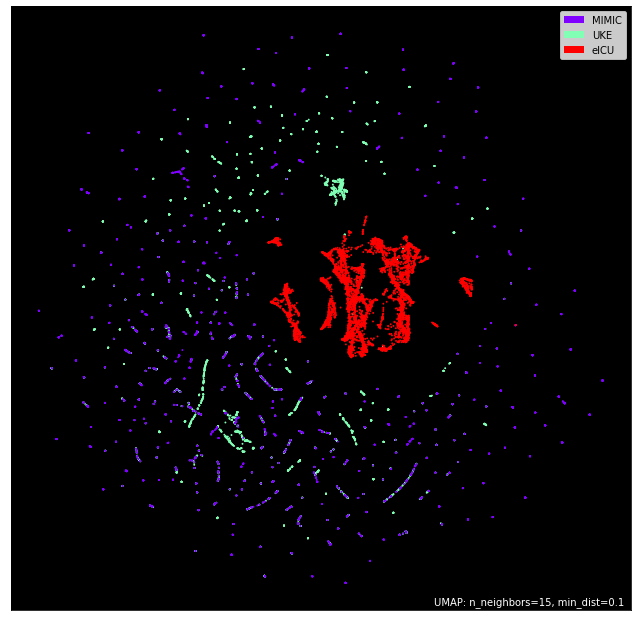

In [1159]:
# yeo all
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

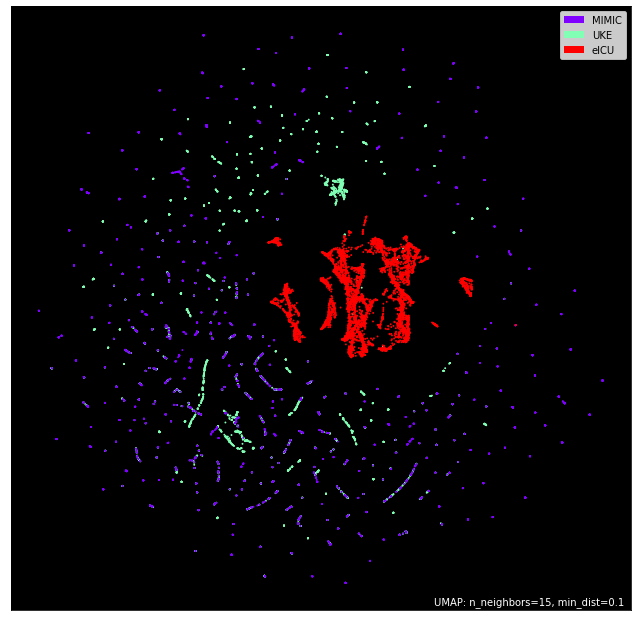

In [1160]:
# all
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

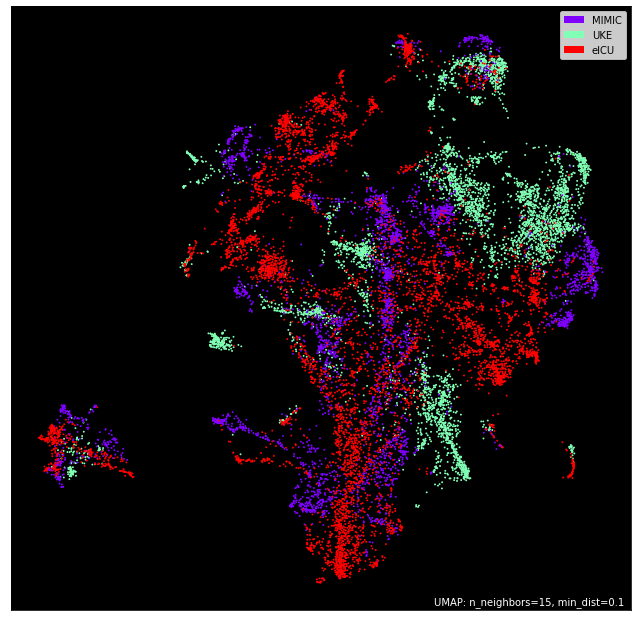

In [1098]:
# all yeo
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

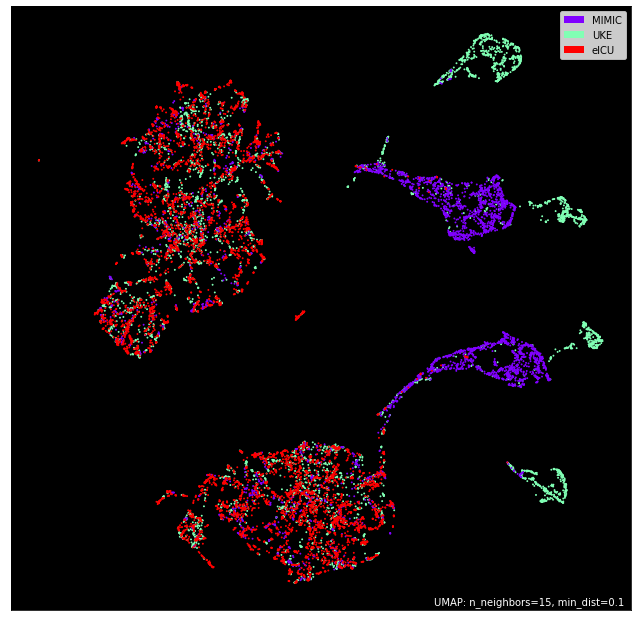

In [482]:
# only static
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

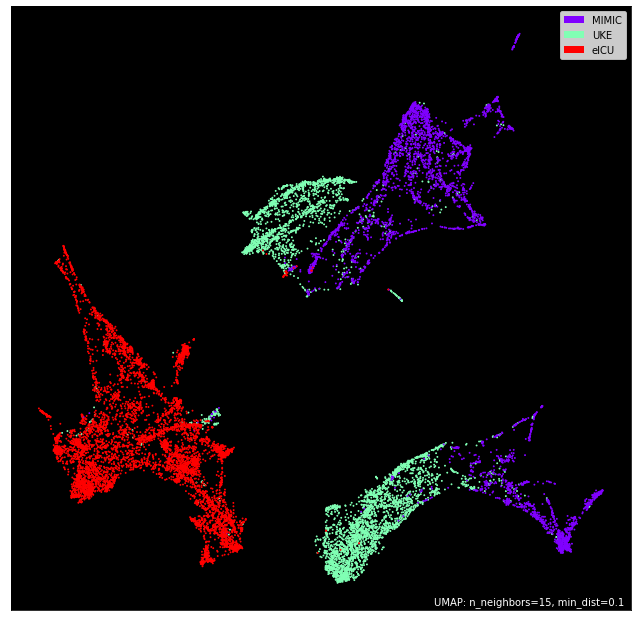

In [467]:
# only vital
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

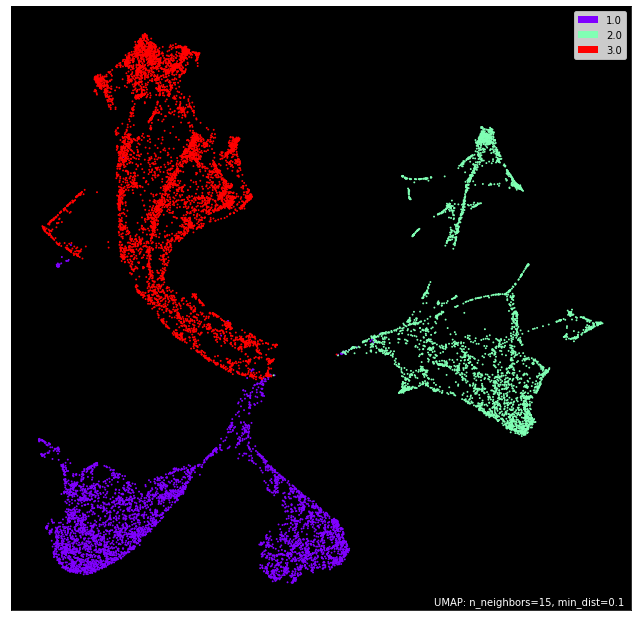

In [453]:
# no med + no diag
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

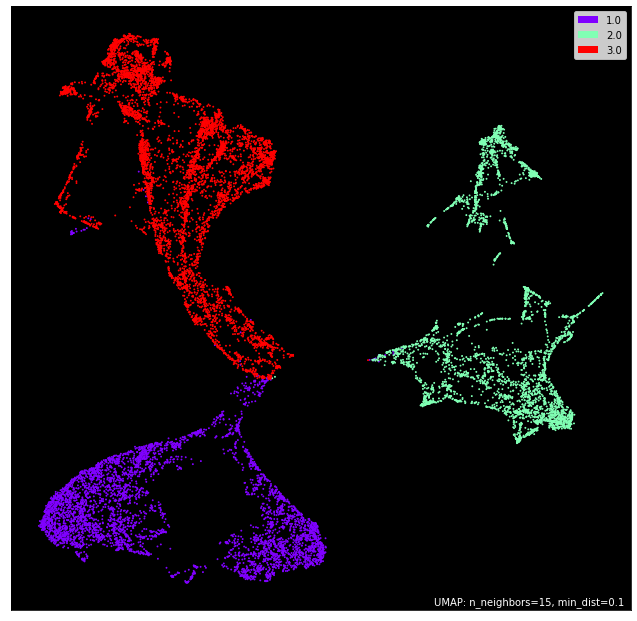

In [446]:
# no med
umap.plot.points(umapper, theme="fire", labels=db_values)

<AxesSubplot:>

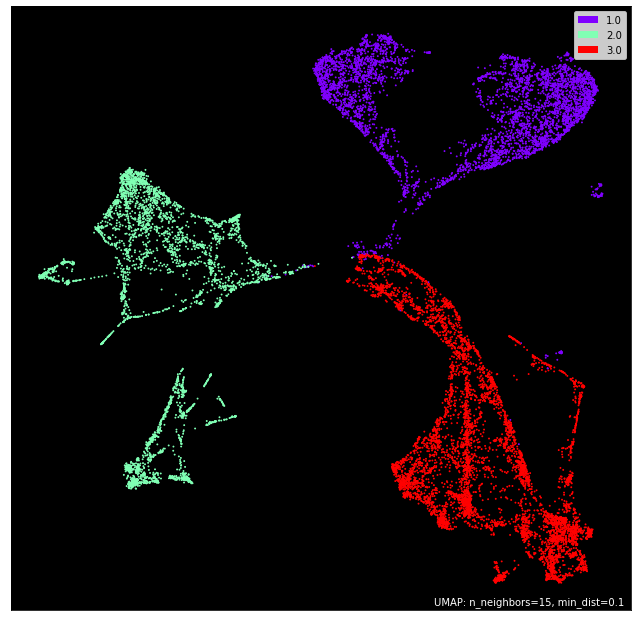

In [434]:
umap.plot.points(umapper, theme="fire", labels=db_values)

In [125]:
list(transformed_df.columns).index("Na_BGA")

42

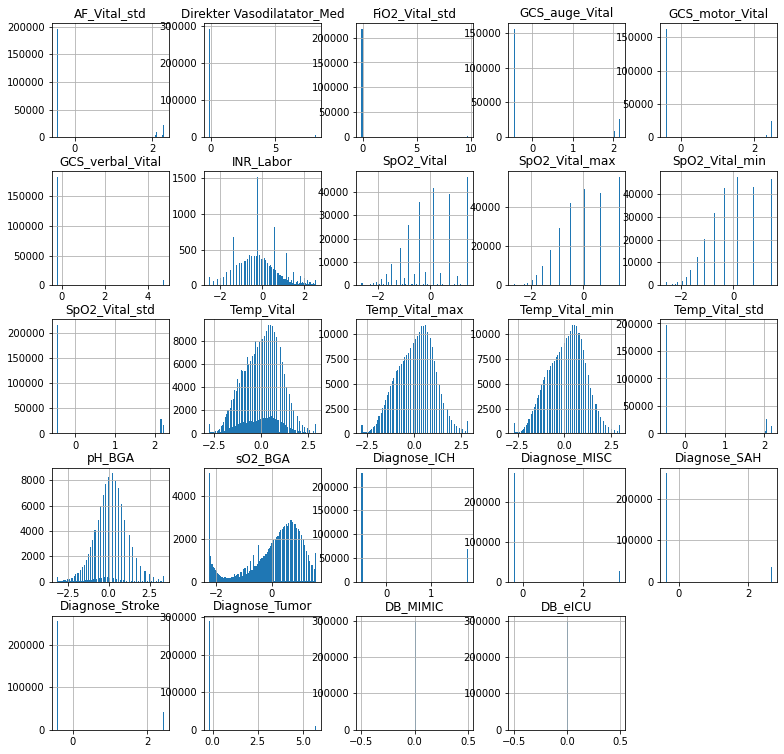

In [141]:
p = transformed_df.loc[:, mask].hist(figsize=(13, 13), bins=100)

In [126]:
# find stds of 0
transformed_df.loc[:, transformed_df.std() == 0]

,Pat_ID,DB_MIMIC,DB_UKE,DB_eICU
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
298251,0.0,0.0,0.0,0.0
298252,0.0,0.0,0.0,0.0
298253,0.0,0.0,0.0,0.0
298254,0.0,0.0,0.0,0.0


In [127]:
transformed_df["sO2_BGA"].describe()

count    1.052320e+05
mean    -1.696141e-16
std      1.000005e+00
min     -2.250734e+00
25%     -4.851976e-01
50%      2.212004e-01
75%      7.215354e-01
max      1.584746e+00
Name: sO2_BGA, dtype: float64

In [128]:
np.quantile(transformed_df["sO2_BGA"].dropna(), 0.9999)

1.5847455974453908

In [129]:
np.quantile(df_large["sO2_BGA"].dropna(), 0.99)

100.0

In [130]:
df_large["sO2_BGA"].describe()

count    115831.000000
mean         95.252581
std           8.033227
min           8.000000
25%          95.800003
50%          97.599998
75%          98.599998
max         997.000000
Name: sO2_BGA, dtype: float64

In [133]:
transformed_df.max()[transformed_df.max() > 5]

Direkter Vasodilatator_Med    8.135718
FiO2_Vital_std                9.695568
ICP_Vital                     5.031238
Katecholamin_Med              7.735633
Opioid_Med                    5.129976
PO2_BGA                       5.141505
Gewicht                       5.394250
Diagnose_Tumor                5.707543
dtype: float64

In [135]:
transformed_df.loc[:, mask]

,AF_Vital_std,Direkter Vasodilatator_Med,FiO2_Vital_std,GCS_auge_Vital,GCS_motor_Vital,GCS_verbal_Vital,INR_Labor,SpO2_Vital,SpO2_Vital_max,SpO2_Vital_min,...,Temp_Vital_std,pH_BGA,sO2_BGA,Diagnose_ICH,Diagnose_MISC,Diagnose_SAH,Diagnose_Stroke,Diagnose_Tumor,DB_MIMIC,DB_eICU
0,NaN,-0.122915,-0.103149,-0.46918,-0.405272,-0.210551,NaN,-1.173476,-1.252715,-1.084215,...,-0.478346,NaN,NaN,-0.552349,-0.307953,-0.372575,-0.409248,-0.175207,0.0,0.0
1,NaN,-0.122915,-0.103149,NaN,-0.405272,-0.210551,NaN,-1.325042,0.022934,-1.965705,...,2.051613,NaN,NaN,-0.552349,-0.307953,-0.372575,-0.409248,-0.175207,0.0,0.0
2,NaN,-0.122915,-0.103149,-0.46918,NaN,NaN,NaN,-0.400323,-0.488374,-0.326029,...,-0.478346,NaN,NaN,-0.552349,-0.307953,-0.372575,-0.409248,-0.175207,0.0,0.0
3,NaN,-0.122915,-0.103149,-0.46918,-0.405272,-0.210551,NaN,-0.823334,-0.908390,-0.739828,...,-0.478346,NaN,NaN,-0.552349,-0.307953,-0.372575,-0.409248,-0.175207,0.0,0.0
4,NaN,-0.122915,NaN,NaN,NaN,NaN,NaN,-1.006717,-1.089143,-0.919962,...,-0.478346,NaN,NaN,-0.552349,-0.307953,-0.372575,-0.409248,-0.175207,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298251,2.294874,-0.122915,-0.103149,-0.46918,-0.405272,-0.210551,NaN,-2.190494,-2.103967,-2.208992,...,-0.478346,NaN,NaN,-0.552349,3.247252,-0.372575,-0.409248,-0.175207,0.0,0.0
298252,-0.450518,-0.122915,-0.103149,-0.46918,-0.405272,-0.210551,NaN,-1.462732,0.644140,-2.208992,...,-0.478346,NaN,NaN,-0.552349,3.247252,-0.372575,-0.409248,-0.175207,0.0,0.0
298253,2.116956,-0.122915,-0.103149,-0.46918,-0.405272,-0.210551,NaN,0.402533,1.397400,-0.326029,...,-0.478346,NaN,NaN,-0.552349,3.247252,-0.372575,-0.409248,-0.175207,0.0,0.0
298254,2.116956,-0.122915,NaN,-0.46918,-0.405272,-0.210551,NaN,0.402533,0.644140,0.170244,...,2.191414,NaN,NaN,-0.552349,3.247252,-0.372575,-0.409248,-0.175207,0.0,0.0


count    142715.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: Na_BGA, dtype: float64

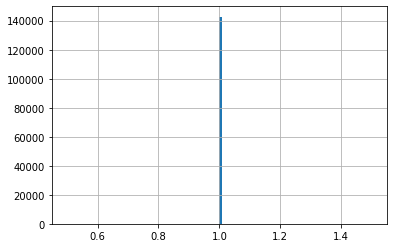

In [38]:
transformed_df["Na_BGA"].hist(bins=100)
transformed_df["Na_BGA"].describe()

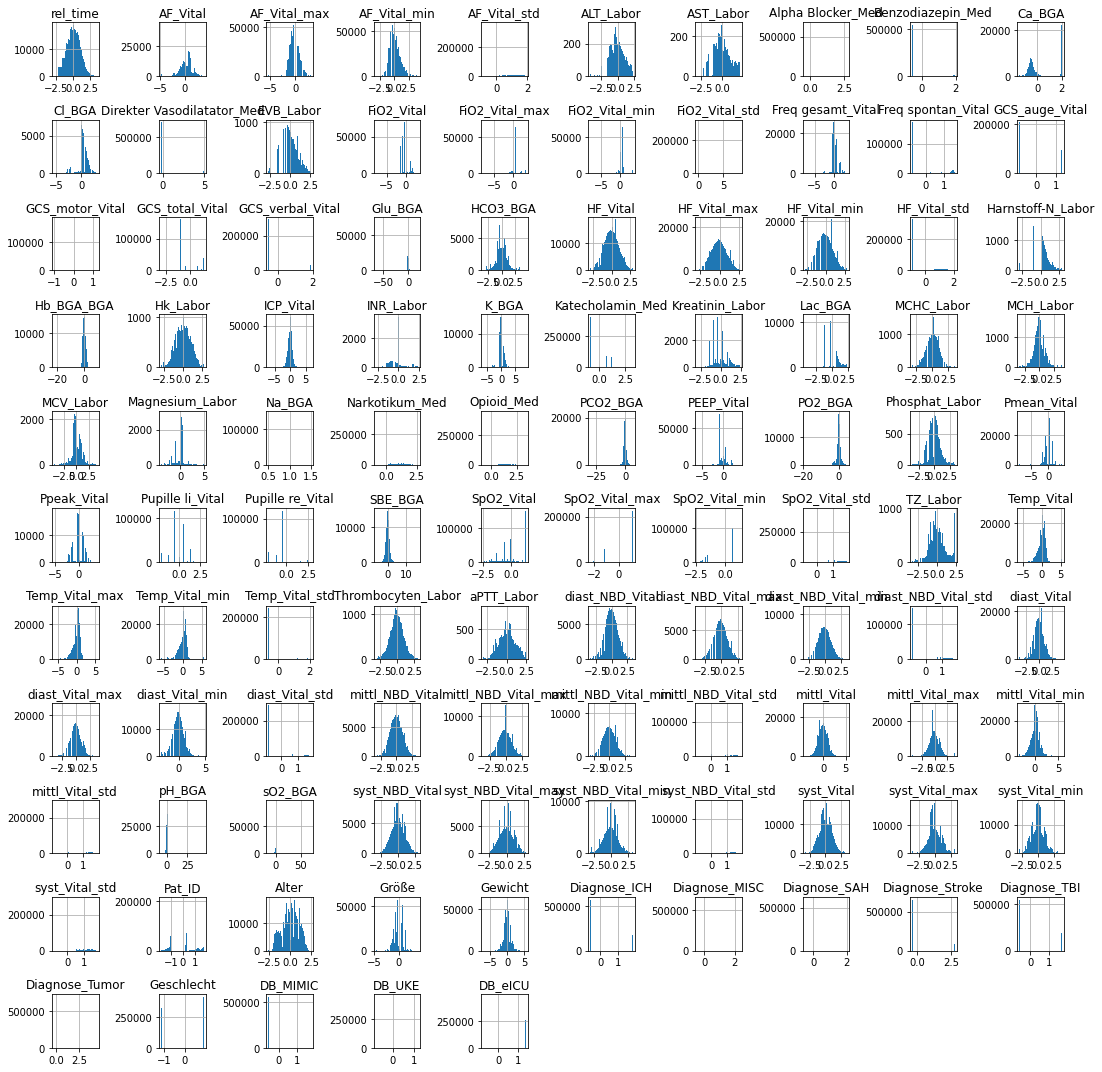

In [29]:
p = transformed_df.hist(bins=100, figsize=(15, 15))
plt.tight_layout()

In [543]:
(~df_large["ICP_Vital"].isna()).sum()

3093093

In [544]:
(~df_large["ICP_Vital"].isna()).sum()

3093093

In [392]:
len(df_large)

8804310

In [393]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

154014

In [394]:
len(df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"])

2118712

In [160]:
# 5 min: 3093093 ICP_Vital non_nans. 154014 in MIMIC
# len total: xxx. MIMIC: 2118712

In [ ]:
# 60 min: 585353 ICP VItal non_nans in total. 128303 in MIMIC
# total steps: 735951. MIMIC: 177102

In [491]:
test_df["Diagnose_Tumor"].isna().mean()

0.7593551340195881

In [490]:
test_df["Alter"].isna().mean()

0.7593551340195881

In [351]:
test_df = pd.read_csv("data/df_final_5.csv")

In [352]:
len(test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"])

2118712

In [353]:
(~test_df[test_df["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

154014

In [349]:
(~df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].isna()).sum()

128303

<AxesSubplot:>

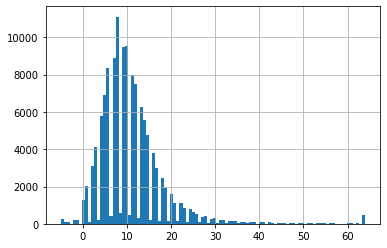

In [345]:
df_large[df_large["DB_MIMIC"] == 1]["ICP_Vital"].hist(bins=100)

In [355]:
pat_ids = []
for db in df_long["DB"].unique():
    subset = df_long[df_long["DB"] == db]
    ids = subset["Pat_ID"].unique()
    pat_ids.append(ids)

In [356]:
id_dict = {}
for id_ in pat_ids[0]:
    id_dict[id_] = 1
    

In [358]:
for id_ in pat_ids[1]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [359]:
for id_ in pat_ids[2]:
    if id_ in id_dict:
        print(id_, "is duplicate!")
        id_dict[id_] = 1

In [421]:
np.isinf(df_large.to_numpy()).sum()

0

In [480]:
# check specific data
clinic = df_large[df_large["DB_UKE"] == 1]
pat_ids = clinic["Pat_ID"].unique()

In [481]:
len(pat_ids)

1180

In [482]:
clinic["ICP_Vital"].isna().mean()

0.2100879781127622

In [483]:
pat_idx = -500

pat_id = pat_ids[pat_idx]
pat = clinic[clinic["Pat_ID"] == pat_id]

<AxesSubplot:xlabel='rel_time'>

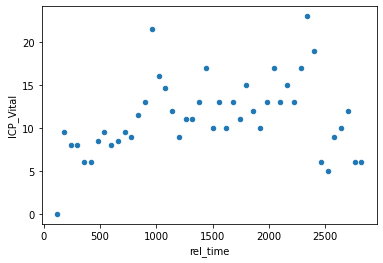

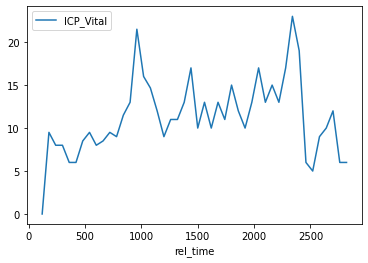

In [484]:
pat.plot.scatter(x="rel_time", y="ICP_Vital")
pat.plot(x="rel_time", y="ICP_Vital")

In [485]:
#pat["HF_Vital"].plot()

In [552]:
uke = df_long[df_long["DB"] == "UKE"]

In [556]:
uke[uke["Maßnahme_norm"] == "FiO2"]

,Pat_ID,Maßnahme,Maßnahme_norm,rel_time,Wert,DB
28179509,474096103,FiO2_Vital,FiO2,31.0,30.0,UKE
28179510,474096103,FiO2_Vital,FiO2,68.0,30.0,UKE
28179511,474096103,FiO2_Vital,FiO2,116.0,30.0,UKE
28179512,474096103,FiO2_Vital,FiO2,171.0,30.0,UKE
28179513,474096103,FiO2_Vital,FiO2,238.0,30.0,UKE
...,...,...,...,...,...,...
95873160,597077779,FiO2_Vital,FiO2,1050.0,80.0,UKE
95873161,597077779,FiO2_Vital,FiO2,1110.0,80.0,UKE
95873162,597077779,FiO2_Vital,FiO2,1170.0,80.0,UKE
95873163,597077779,FiO2_Vital,FiO2,1229.0,80.0,UKE


In [ ]:
nan_frac_per_db = df_filled.groupby("DB").apply(lambda: db.isna().mean())

In [ ]:
nan_frac_per_db

In [561]:
for col in df_filled.columns:
    nan_means = df_filled.groupby("DB").apply(lambda db: db[col].isna().mean())
    print(col)
    print(nan_means)
    print()
    if max(nan_means) > 0.99:
        print("Drop: ", col)

rel_time
DB
MIMIC    0.0
UKE      0.0
eICU     0.0
dtype: float64

AF_Vital
DB
MIMIC    0.908069
UKE      0.887768
eICU     0.115498
dtype: float64

AF_Vital_max
DB
MIMIC    0.908069
UKE      0.887768
eICU     0.115498
dtype: float64

AF_Vital_min
DB
MIMIC    0.908069
UKE      0.887768
eICU     0.115498
dtype: float64

AF_Vital_std
DB
MIMIC    0.908069
UKE      0.887768
eICU     0.115498
dtype: float64



KeyboardInterrupt: 

In [550]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_BGA"].mean())

DB
MIMIC    55.684917
UKE            NaN
eICU     50.769941
dtype: float64

In [557]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].mean())

DB
MIMIC    48.890708
UKE      31.440665
eICU     43.008389
dtype: float64

In [558]:
df_filled.groupby("DB").apply(lambda db: db["FiO2_Vital"].std())

DB
MIMIC    13.755537
UKE      10.931145
eICU     15.472664
dtype: float64

In [1]:
df_large["FiO2_BGA"]

NameError: name 'df_large' is not defined

In [ ]:
# FiO2 does not exist in UKE